# **Zero-Shot Unsupervised Text Classification using Sentence Transformers**

In this work, we address the task of sentiment analysis on the Rotten Tomatoes dataset in an **unsupervised setting**, without utilizing its provided labels. This approach is motivated by scenarios where the text data lacks annotations, and the objective is to classify the data into predefined categories.

---

## **Methodology**

Our methodology involves the following steps:

1. **Text Embedding Generation**  
   We use Sentence Transformers to compute embeddings for the text samples, capturing their semantic representations.

2. **Clustering**  
   We apply the K-Means++ clustering algorithm to partition the embeddings into two clusters, corresponding to the two sentiment categories (positive and negative).

3. **Cluster Identification**  
   To identify the sentiment associated with each cluster, we calculate the cosine similarity between the cluster centroids and the embeddings of predefined reference sentences:  
   - *"A positive movie review"*  
   - *"A negative movie review"*  
   This allows us to assign sentiment labels to the clusters.

4. **Classification**  
   For test data, we compute the cosine similarity between their embeddings and the identified cluster centroids. Based on the highest similarity, each test sample is classified into the corresponding sentiment.

---

This approach demonstrates an application of unsupervised techniques for sentiment analysis, leveraging semantic embeddings and clustering to achieve meaningful classification without reliance on labeled data.



---
**Note: This markdown description was written with the assistance of ChatGPT, while the ideas are entirely self-derived.**



In [ ]:
# Install necessary packages
!pip install datasets transformers sentence-transformers sklearn matplotlib numpy

In [1]:
# Rotten_tomatoes data

from datasets import load_dataset

# Load our data
data = load_dataset("rotten_tomatoes")
data

/home/ubuntu/miniconda3/envs/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

## Generate Embeddings of the text data

In [2]:
from sentence_transformers import SentenceTransformer

# Load model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Convert text to embeddings
train_embeddings = model.encode(data["train"]["text"], show_progress_bar=True)
test_embeddings = model.encode(data["test"]["text"], show_progress_bar=True)

Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.80it/s]


## **PCA** Decomposition for visualization

In [3]:
from sklearn.decomposition import PCA
import numpy as np

def dim_reduction(X):    
    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    return X_reduced

## Data Visualization

#### We utilize PCA to reduce the dimensionality of embeddings for effective visualization.

Centroids: [[-0.17289397 -0.01497189]
 [ 0.14722446  0.01274901]]


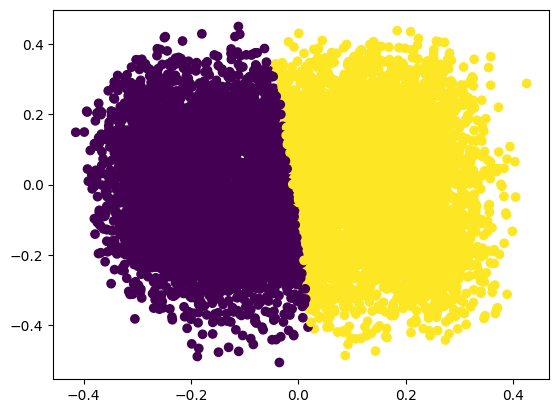

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Apply K-Means++
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0)
X_train = dim_reduction(train_embeddings)
kmeans.fit(X_train)

# Scatter plot of data points
plt.scatter(X_train[:, 0], X_train[:, 1], c=kmeans.labels_, cmap='viridis', label='Data Points')

# Cluster centroids
print("Centroids:", kmeans.cluster_centers_)

In [5]:
# Apply K-Means++ on train_embeddings

kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0)
kmeans.fit(train_embeddings)

KMeans(n_clusters=2, random_state=0)

In [6]:
# Create embeddings for our sentiment labels (Labels are self-improvised)
label_embeddings = model.encode(["One Negative movie review",  "One Positive movie review"])

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Find the matching sentiment label for the centroids using Cosine Similarity
sim_matrix = cosine_similarity(kmeans.cluster_centers_, label_embeddings)
centroid_label_mapping = np.argmax(sim_matrix, axis=1)

In [8]:
centroid_embeddings = kmeans.cluster_centers_[centroid_label_mapping]

In [9]:
# Find the matching label for the centroids using Cosine Similarity
sim_matrix = cosine_similarity(test_embeddings, centroid_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [10]:
from sklearn.metrics import classification_report

def evaluate_performance(y_true, y_pred):
    """Create and print the classification report"""
    performance = classification_report(
        y_true, y_pred,
        target_names=["Negative Review", "Positive Review"]
    )
    print(performance)

In [11]:
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.83      0.82      0.83       533
Positive Review       0.82      0.83      0.83       533

       accuracy                           0.83      1066
      macro avg       0.83      0.83      0.83      1066
   weighted avg       0.83      0.83      0.83      1066

